In [1]:
%matplotlib inline
import numpy as np

from matplotlib import pyplot as plt

In [2]:
# wavelength database:

NEON_WAVELN = {
    532.640 : 20,
    533.078 : 60,
    533.331 : 0,
    533.571 : 0, 
    534.109 : 100,
    534.328 : 60,
    534.920 : 0,
    535.516 : 0,
    535.542 : 0,
    535.802 : 0,
    536.001 : 0,
    536.042 : 0,
    536.223 : 0,
    537.231 : 0,
    537.498 : 0,
    538.325 : 0,
    540.056 : 200,
    541.265 : 0,
    541.856 : 0,
}

In [3]:
# spectral fit output:

spectral_lines = np.array([
    22.181795919847822,
    41.140395614525275,
    144.26273501671918,
    186.4979599536216,
    292.1601184580567,
    335.21179409990134,
    377.61005873042376,
    414.14821455025987,
    445.4639986187941,
])

In [4]:
WLN_RES_FILTER_NM = 0.0 #0.2

In [5]:
def combine(a, b):
    return np.array(np.meshgrid(a[:, np.newaxis], b[np.newaxis, :])).T.reshape(-1, 2)

In [6]:
is_sorted = lambda a: np.all(a[:-1] <= a[1:])

In [7]:
def get_dispersion_hint():
    # Ref: Calculations by Jordy
    
    wavelength = 532 # nm
    focal_length = 1000 # mm
    groove_density = 1800 # gr/mm
    d = 1 / groove_density # mm --> why not used??
    m = 1 # diffraction_order --> one, so left out
    
    blaze_angle = 28.6 # deg
    # Littrow configuration

    linear_disp = wavelength / (2 * focal_length * np.tan(blaze_angle / 180 * np.pi)) # nm/mm--> focal length in mm, rest in nm??
    
    # pixel_size = 16 # um --> hmm.. should be nm??
    pixel_size = 16000 #nm 
    fiber_optic_taper = 1.48 # units?
    ccd_size = 512 # pixels
    
    # conversion to nm/pixel
    dispersion_hint = linear_disp * pixel_size * fiber_optic_taper / 1000 # nm/pixel
    spectral_range = dispersion_hint * ccd_size # nm  --> unused
    print(f"Dispersion hint: {dispersion_hint:.2f} nm/pixel")
    return dispersion_hint

 ramman spectrometer
    litrov
    blazing angle --> alpha = beta


In [8]:
# def get_dispersion_hint():
#     # Constants
#     wavelength = 532  # nm
#     focal_length = 1000  # mm
#     groove_density = 1800  # gr/mm
#     diffraction_order = 1
#     blaze_angle = 28.6  # deg
    
#     # Convert blaze angle to radians
#     blaze_angle_rad = np.radians(blaze_angle)
    
#     # Grating period
#     d = 1 / groove_density * 1e6  # nm
    
#     # General grating equation
#     # d(sin(α) + sin(β)) = mλ
#     # Assuming α (incident angle) = blaze_angle
#     # Solve for β (diffraction angle)
#     beta = np.arcsin(diffraction_order * wavelength / d - np.sin(blaze_angle_rad))
    
#     # Calculate angular dispersion
#     angular_dispersion = diffraction_order / (d * np.cos(beta))  # rad/nm
    
#     # Convert to linear dispersion
#     linear_disp = focal_length * angular_dispersion #* 1e6  # nm/mm
    
#     # Rest of the calculation remains the same
#     pixel_size = 16  # um
#     fiber_optic_taper = 1.48
#     ccd_size = 512  # pixels
    
#     dispersion_hint = linear_disp * pixel_size * fiber_optic_taper / 1000  # nm/pixel
#     # spectral_range = dispersion_hint * ccd_size  # nm
#     print(f"Dispersion hint: {dispersion_hint:.2f} nm/pixel")
#     return dispersion_hint


In [9]:
def find_wl_match(spl, wldb, _disp=None):
    """
    Find spectral database offset for given peak results.
    spl: spectral lines
    wldb: wavelength database
    _disp: dispersion hint
    """
   
    # convert peak database into array
    wldba = np.asarray(sorted(wldb))
    
    # delete lines from database that are closer than minimum resolution
    wldba = np.delete(wldba, 1 + np.nonzero(np.abs(np.diff(wldba)) < WLN_RES_FILTER_NM)[0])
    
    # calculate preliminary dispersion based on the closest (Ne) peak doublet
    # (which should be in the spectrum)
    if not _disp:
        # _disp =1
        _disp = np.nanmin(np.diff(wldba)) / np.nanmin(np.diff(spl))

    # create a combined array of found peaks versus peak database
    splma = combine(spl, wldba)
    
    # compare relative wavelength positions
    splmd = np.full((len(spl), len(wldba)), np.nan)
    for i in range(len(spl)):
        sel = splma[i::len(wldba)+1]
        
        if not is_sorted(sel[:, 1]):
            sel = sel[:np.nanargmax(sel[:, 1]) + 1]        
        
        if len(sel) > 1:
            sub = np.abs(
                np.diff(_disp * sel[:, 0]) - np.diff(sel[:, 1]))
            splmd[i, :len(sub)] = np.roll(sub, i)
    
    wl_oi = int(np.round(np.nanargmin([np.nanmin(
        splmd[i::len(wldba)+1]) for i in range(len(wldba)) 
            if not np.all(np.isnan(splmd[i::len(wldba)+1]))])))
    
    # return adapted wavelength database
    return wldba[wl_oi:]

In [10]:
def remove_faulty_peaks(spl, wldb):
    """
    Remove peak results that do not match the spectral database.
    """
    _disp = get_dispersion_hint() # theoretical dispersion
    # _disp = 0.8  
    wlm = find_wl_match(spl, wldb, _disp=_disp)
    for _ in range(max(len(spl), len(wldb))):
        
        # calculate dispersion test
        dschk = np.diff(wlm[:len(spl)]) / np.diff(spl[:len(wlm)])
        
        if not dschk.any():
            continue
        
        # (experimental) check to determine invalid peak results
        ivchk = np.abs(dschk / _disp - 1) > 0.1
        itchk = dschk / _disp - 1 < 0
        
        if not np.any(ivchk):
            break # all peaks ok
        
        # get first faulty peak
        fidx = 1 + ivchk.nonzero()[0][0]
        
        if itchk[fidx - 1]:
            # invalidate wavelength db result
            wlm = np.delete(wlm, fidx)
        else:
            # invalidate peak result
            spl = np.delete(spl, fidx)

        # re-calculate database match
        wlm = find_wl_match(spl, wlm, _disp=_disp)
    
    # return matches
    return spl[:len(wlm)], wlm[:len(spl)][~np.isnan(spl[:len(wlm)])]

In [11]:
# secret sauce to match found peaks to known database
spectral_lines, neon_waveln = remove_faulty_peaks(spectral_lines, NEON_WAVELN)

# calculate dispersion
dispersion = np.nanmean(np.diff(neon_waveln)) / np.nanmean(np.diff(spectral_lines)) # nm/px
print(f"Dispersion: {dispersion:.10f} nm/px")

Dispersion hint: 11.55 nm/pixel


ValueError: could not broadcast input array from shape (4,) into shape (1,)

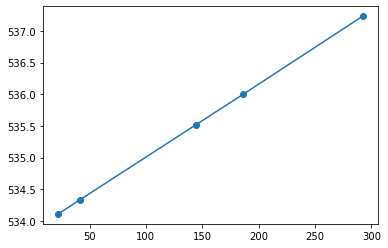

In [ ]:
plt.plot(spectral_lines, neon_waveln, 'o-')